cuda:0


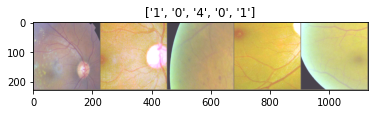

In [ ]:
from __future__ import print_function, division

import torch
torch.cuda.is_available()
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
torch.cuda.is_available()
from PIL import ImageFile
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ImageFile.LOAD_TRUNCATED_IMAGES = True
print(device)

# apply transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.2502, 0.1466, 0.0367], [0.2741, 0.1658, 0.0637])
    ]),
    'eval': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.2502, 0.1466, 0.0367], [0.2741, 0.1658, 0.0637])
    ]),
}


# import data and setup dataloaders
train_data = datasets.ImageFolder("/home/train", transform=data_transforms['train'])
eval_data = datasets.ImageFolder("/home/val", transform=data_transforms['eval'])
dataset_sizes = {}
dataset_sizes['train'] = len(train_data)
dataset_sizes['eval'] = len(eval_data)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True, num_workers = 2)
eval_dataloader = torch.utils.data.DataLoader(eval_data, batch_size=5, shuffle=False, num_workers = 2)
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['eval'] = eval_dataloader

class_names = train_data.classes

################################################################################
################################################################################

# quick data visualization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
inputs, classes = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
plt.show()

################################################################################
################################################################################
# START TRAINING THE MODEL


def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    #since = time.time() # not strictly needed
    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for i in range(num_epochs):
        print('Epoch ' + str(i))

        # shluld we train for 30 epochs and then validate? Or alternate?
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train() # run model in TRAINING mode
            if phase == 'eval':
                model.eval()  # run model in EVALUATION mode


            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # wtf is this lol
                labels = labels.to(device) # need to specify CPU?


                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Best val Acc: {best_acc:4f}')
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#VGG16
import tensorflow as tf
import matplotlib.pyplot as plt
# base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (32,32,3))
# for layer in base_model.layers:
#   layer.trainable = False
# base_model.summary()

# model_ft2 = torchvision.models.vgg16(pretrained=True)
# num_ftrs2 = model_ft2.classifier[0].in_features
# model_ft2.fc = nn.Linear(num_ftrs2, 5) # 5 classes (0-4)

# model_ft2 = model_ft2.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer_ft2 = optim.SGD(model_ft2.parameters(), lr=0.001, momentum=0.9) # need to do something better here?

# # # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler2 = lr_scheduler.StepLR(optimizer_ft2, step_size=7, gamma=0.1)
# # # TRAIN THE NET

# base_model = train_model(model_ft2, criterion, optimizer_ft2, exp_lr_scheduler2, num_epochs=20)
#started at 10:33PM Wed Nov30

model = Sequential()
model.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3, 3),
                 padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss=keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

# ######################################################################

Epoch 0
train Loss: 1.4019 Acc: 0.5146
eval Loss: 0.9970 Acc: 0.6373
Epoch 1
train Loss: 0.9170 Acc: 0.6770
eval Loss: 0.8107 Acc: 0.7157
Epoch 2
train Loss: 0.7879 Acc: 0.7140
eval Loss: 0.6902 Acc: 0.7266
Epoch 3
train Loss: 0.7347 Acc: 0.7279
eval Loss: 0.5818 Acc: 0.7832
Epoch 4
train Loss: 0.6873 Acc: 0.7396
eval Loss: 0.5396 Acc: 0.8115
Epoch 5
train Loss: 0.6876 Acc: 0.7377
eval Loss: 0.5716 Acc: 0.7865
Epoch 6
train Loss: 0.6567 Acc: 0.7458
eval Loss: 0.5243 Acc: 0.7919
Epoch 7
train Loss: 0.5618 Acc: 0.7802
eval Loss: 0.4690 Acc: 0.8105
Epoch 8
train Loss: 0.5307 Acc: 0.7981
eval Loss: 0.4492 Acc: 0.8268
Epoch 9
train Loss: 0.5404 Acc: 0.7992
eval Loss: 0.4624 Acc: 0.8170
Epoch 10
train Loss: 0.5286 Acc: 0.7857
eval Loss: 0.4576 Acc: 0.8246
Epoch 11
train Loss: 0.5248 Acc: 0.7996
eval Loss: 0.4633 Acc: 0.8290
Epoch 12
train Loss: 0.5085 Acc: 0.8050
eval Loss: 0.4738 Acc: 0.8214
Epoch 13
train Loss: 0.5073 Acc: 0.8124
eval Loss: 0.4483 Acc: 0.8214
Epoch 14
train Loss: 0.5195 Ac

In [ ]:

################################################################################
################################################################################

#GoogleNet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

######################################################################

Epoch 0
train Loss: 1.0658 Acc: 0.6251
eval Loss: 0.7447 Acc: 0.7386
Epoch 1
train Loss: 0.9255 Acc: 0.6631
eval Loss: 0.6803 Acc: 0.7288
Epoch 2
train Loss: 0.8607 Acc: 0.6993
eval Loss: 0.6585 Acc: 0.7702
Epoch 3
train Loss: 0.7762 Acc: 0.7238
eval Loss: 0.5759 Acc: 0.8061
Epoch 4
train Loss: 0.8009 Acc: 0.7249
eval Loss: 0.5510 Acc: 0.7919
Epoch 5
train Loss: 0.7225 Acc: 0.7443
eval Loss: 0.6134 Acc: 0.7952
Epoch 6
train Loss: 0.7484 Acc: 0.7436
eval Loss: 0.5250 Acc: 0.8061
Epoch 7
train Loss: 0.6326 Acc: 0.7666
eval Loss: 0.4547 Acc: 0.8224
Epoch 8
train Loss: 0.6072 Acc: 0.7798
eval Loss: 0.4626 Acc: 0.8170
Epoch 9
train Loss: 0.6203 Acc: 0.7798
eval Loss: 0.4596 Acc: 0.8159
Epoch 10
train Loss: 0.6159 Acc: 0.7780
eval Loss: 0.4650 Acc: 0.8192
Epoch 11
train Loss: 0.5995 Acc: 0.7791
eval Loss: 0.4481 Acc: 0.8257
Epoch 12
train Loss: 0.5979 Acc: 0.7776
eval Loss: 0.4551 Acc: 0.8290
Epoch 13
train Loss: 0.6055 Acc: 0.7871
eval Loss: 0.4526 Acc: 0.8301
Epoch 14
train Loss: 0.5569 Ac

In [ ]:

################################################################################
################################################################################

#GoogleNet
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=28)

######################################################################

Epoch 0
train Loss: 1.1600 Acc: 0.5874
eval Loss: 0.7132 Acc: 0.7440
Epoch 1
train Loss: 0.9561 Acc: 0.6664
eval Loss: 0.6533 Acc: 0.7462
Epoch 2
train Loss: 0.9105 Acc: 0.6727
eval Loss: 0.5606 Acc: 0.7843
Epoch 3
train Loss: 0.8899 Acc: 0.6803
eval Loss: 0.6393 Acc: 0.7603
Epoch 4
train Loss: 0.8377 Acc: 0.6949
eval Loss: 0.5428 Acc: 0.8072
Epoch 5
train Loss: 0.8153 Acc: 0.7080
eval Loss: 0.6494 Acc: 0.7582
Epoch 6
train Loss: 0.7955 Acc: 0.7046
eval Loss: 0.5324 Acc: 0.7952
Epoch 7
train Loss: 0.6717 Acc: 0.7549
eval Loss: 0.4893 Acc: 0.8061
Epoch 8
train Loss: 0.6622 Acc: 0.7552
eval Loss: 0.5019 Acc: 0.8170
Epoch 9
train Loss: 0.6646 Acc: 0.7562
eval Loss: 0.5026 Acc: 0.8094
Epoch 10
train Loss: 0.6404 Acc: 0.7559
eval Loss: 0.5190 Acc: 0.7996
Epoch 11
train Loss: 0.6283 Acc: 0.7708
eval Loss: 0.4682 Acc: 0.8203
Epoch 12
train Loss: 0.6197 Acc: 0.7691
eval Loss: 0.4728 Acc: 0.8214
Epoch 13
train Loss: 0.6324 Acc: 0.7708
eval Loss: 0.4868 Acc: 0.8148
Epoch 14
train Loss: 0.6191 Ac

In [ ]:

################################################################################

#GoogleNet
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=28)

######################################################################

Epoch 0
train Loss: 1.2304 Acc: 0.5516
eval Loss: 1.1909 Acc: 0.5969
Epoch 1
train Loss: 1.1642 Acc: 0.5801
eval Loss: 0.9921 Acc: 0.6460
Epoch 2
train Loss: 1.0810 Acc: 0.6130
eval Loss: 0.9386 Acc: 0.6285
Epoch 3
train Loss: 1.0285 Acc: 0.6379
eval Loss: 0.9432 Acc: 0.6612
Epoch 4
train Loss: 1.0280 Acc: 0.6240
eval Loss: 0.9187 Acc: 0.6612
Epoch 5
train Loss: 0.9808 Acc: 0.6536
eval Loss: 1.0116 Acc: 0.6590
Epoch 6
train Loss: 1.0079 Acc: 0.6459
eval Loss: 0.9383 Acc: 0.6514
Epoch 7
train Loss: 0.9489 Acc: 0.6609
eval Loss: 0.8776 Acc: 0.6710
Epoch 8
train Loss: 0.9110 Acc: 0.6712
eval Loss: 0.8758 Acc: 0.6797
Epoch 9
train Loss: 0.9065 Acc: 0.6756
eval Loss: 0.8794 Acc: 0.6721
Epoch 10
train Loss: 0.9048 Acc: 0.6796
eval Loss: 0.8790 Acc: 0.6808
Epoch 11
train Loss: 0.8867 Acc: 0.6862
eval Loss: 0.8677 Acc: 0.6776
Epoch 12
train Loss: 0.8801 Acc: 0.6957
eval Loss: 0.8569 Acc: 0.6819
Epoch 13
train Loss: 0.8815 Acc: 0.6902
eval Loss: 0.8980 Acc: 0.6797
Epoch 14
train Loss: 0.8769 Ac

In [ ]:
################################################################################
################################################################################

#GoogleNet
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=28)

######################################################################

Epoch 0
train Loss: 1.0183 Acc: 0.6368
eval Loss: 0.6156 Acc: 0.7691
Epoch 1
train Loss: 0.8359 Acc: 0.7034
eval Loss: 0.7642 Acc: 0.7429
Epoch 2
train Loss: 0.8206 Acc: 0.6997
eval Loss: 0.6175 Acc: 0.7538
Epoch 3
train Loss: 0.7275 Acc: 0.7337
eval Loss: 0.5651 Acc: 0.7941
Epoch 4
train Loss: 0.7202 Acc: 0.7374
eval Loss: 0.5735 Acc: 0.7930
Epoch 5
train Loss: 0.6932 Acc: 0.7560
eval Loss: 0.4922 Acc: 0.8050
Epoch 6
train Loss: 0.6581 Acc: 0.7612
eval Loss: 0.5254 Acc: 0.8007
Epoch 7
train Loss: 0.5861 Acc: 0.7864
eval Loss: 0.4820 Acc: 0.8214
Epoch 8
train Loss: 0.5584 Acc: 0.7985
eval Loss: 0.4821 Acc: 0.8279
Epoch 9
train Loss: 0.5283 Acc: 0.7992
eval Loss: 0.4723 Acc: 0.8355
Epoch 10
train Loss: 0.5515 Acc: 0.7992
eval Loss: 0.4748 Acc: 0.8355
Epoch 11
train Loss: 0.5305 Acc: 0.8040
eval Loss: 0.4838 Acc: 0.8301
Epoch 12
train Loss: 0.5423 Acc: 0.8050
eval Loss: 0.4634 Acc: 0.8333
Epoch 13
train Loss: 0.5398 Acc: 0.8091
eval Loss: 0.4727 Acc: 0.8301
Epoch 14
train Loss: 0.5184 Ac

In [ ]:

################################################################################

#GoogleNet
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

######################################################################

Epoch 0
train Loss: 1.2247 Acc: 0.5479
eval Loss: 1.3175 Acc: 0.4902
Best val Acc: 0.490196


In [ ]:
################################################################################

#GoogleNet
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 5) # 5 classes (0-4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum = 0.9) # need to do something better here?

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# TRAIN THE NET

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

######################################################################

Epoch 0
train Loss: 1.0007 Acc: 0.6522
eval Loss: 0.7599 Acc: 0.7179
Best val Acc: 0.717865
